# Redes sociais - P1
Fernando Fincatti, Gabriela Moreno, Gabriella Cukier e Manuel Castanares

---

### Importando bibliotecas
---

In [1]:
import netpixi
from netpixi.data.gt import *
import cpnet
from graph_tool import spectral
import pandas as pd
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
sns.set()
from matplotlib import rcParams
import statsmodels.formula.api as smf
import csv
import pandas as pd
from graph_tool import util
from graph_tool import Graph
from utils import *
from graph_tool import clustering

import seaborn as sns
sns.set()

# Análise ANTES da década de 1990

### Carrega dados
---

In [2]:
#carrega dados
df = pd.read_csv('athlete_events.csv')
df_noc = pd.read_csv('noc_regions.csv')
df_gdp = pd.read_csv('countries of the world.csv')

In [3]:
#junta ambas as tabelas
df_merge_original=df.merge(df_noc,how="left",on="NOC")

#dropa linhas sem a região
df_merge_original=df_merge_original.dropna(subset=['region'])

In [4]:
#filtra somente datas posteriores a 1970
df_merge_before=df_merge_original[df_merge_original["Year"] >= 1970]
df_merge_before=df_merge_before[df_merge_before["Year"] <= 1990]

### Análise
---

In [5]:
#cria grafo não-dirigido
g = Graph(directed=False)
c = Graph(directed=False) 

In [6]:
df_merge_before['desempenho'] = df_merge_before['Medal'].apply(lambda x: desempenho(x))

#dropa valores duplicados
df_desempenho = df_merge_before.drop_duplicates(subset=["Year","Sport","region"])

#remove paises com desempenho 0
df_desempenho = df_desempenho.loc[df_desempenho.desempenho>0]

#pega o desempenho por país por esporte
df_desempenho_pais = df_desempenho[["Sport", "region", "desempenho"]].groupby(["Sport", "region"], as_index=False).sum()

#calcula o desemepnho médio por esporte
df_desempenho_media = df_desempenho_pais.groupby(["Sport"]).mean()

#adiciona o desempenho médio por esporte na tabela
df_desempenho_pais["media"] = df_desempenho_pais["Sport"].apply(lambda x: 
              media(x, df_desempenho_media))

#ajusta nome dos países na tabela
df_gdp['Country'] = df_gdp['Country'].apply(lambda x: elimina_ultimo_caracter(x))

#dicionário com os nomes corretos
dic_paises_nome = {
    'South Korea': 'Korea, South',
    'USA': 'United States',
    'UK': 'United Kingdom',
    'North Korea': 'Korea, North',
    'Ivory Coast': "Cote d'Ivoire"
}

#acerta o nome dos países
df_desempenho_pais['region'] = df_desempenho_pais['region'].apply(lambda x: acerta_nome_paises(x, dic_paises_nome)) 

#pega informações sobre cada país
df_desempenho_pais = df_desempenho_pais.merge(df_gdp[["Country","GDP ($ per capita)"]],
                                              how='left',
                                              left_on="region",
                                              right_on="Country",)

#remove alguns países irrelevantes
df_desempenho_pais = df_desempenho_pais.dropna(subset=['GDP ($ per capita)'])


In [7]:
df_desempenho_pais.head()

,Sport,region,desempenho,media,Country,GDP ($ per capita)
0,Alpine Skiing,Czech Republic,1,1.50,Czech Republic,15700.0
1,Alpine Skiing,Switzerland,2,1.50,Switzerland,32700.0
2,Archery,Finland,1,2.25,Finland,27400.0
3,Archery,Japan,2,2.25,Japan,28200.0
4,Archery,Russia,3,2.25,Russia,8900.0


In [8]:
#pega todos os times
lista_teams = df_desempenho_pais.region.unique().tolist()

#pega todos os eventos
lista_eventos = df_desempenho_pais.Sport.unique().tolist()

g.vp['tipo'] = g.new_vp('object')
g.vp['nome'] = g.new_vp('object')
g.vp['color'] = g.new_vp('object')

lista_vertices = lista_teams+lista_eventos

#cria os times como vértices
cria_vertices(g, lista_vertices, len(lista_teams))
print('número de vértices de g:', g.num_vertices())

lista_arestas = list()

#preenche a lista e o dicionario de acordo com as partidas e ocorrencias
df_fake = df_desempenho_pais.apply(lambda x: 
              arestas(x.region, x.Sport, x.desempenho, x.media, lista_arestas),
              axis=1)

create_edgs_links(lista_arestas, g)

número de vértices de g: 91


### Análise 2
---

In [9]:
c.vp['nome'] = c.new_vp('object') #adiciona propriedade aos vértices
c.ep['peso'] = c.new_ep('object') #adiciona propriedade as arestas

cria_nome_times(g, c) #cria vertíces

dicionario_one_mode, lista_one_mode = lista_esporte_por_time(g)

dist = cria_arestas(c, dicionario_one_mode, lista_one_mode)

### Visualizando grafo C
---

In [10]:
m = draw_gt.sfdp_layout(c)
move_gt(c, m)

save_gt(c, 'exemplo_c.net.gz')

r = netpixi.render('./exemplo_c.net.gz', infinite=True)

In [11]:
r.graph(kscale=5) # Isto aumenta o tamanho dos nomes.
r.vertex_default(size=6)
r.vertex_set_key('nome')
r.edge_scale('peso', 1, 3)

### Cluster coefficient
---

In [12]:
cluster = clustering.local_clustering(c)

c.vp['clustering coefficient'] = cluster

dft = pd.DataFrame({k: list(v) for k, v in c.vp.items()})

dft = dft.loc[dft['clustering coefficient'] != 0]

### Salvando grafo e visualizando
---

In [13]:
top = []
for v in g.vertices():
    if g.vp['tipo'][v] == 'time':
        top.append(v)
        
m = draw_gt.bipartite_layout(g, top)
move_gt(g, m)

save_gt(g, 'exemplo.net.gz')

r = netpixi.render('./exemplo.net.gz')

In [14]:
# mudar a cor de fundo do grafo
r.graph(color=0xffffff)

# mudar a cor e o tamanho dos vértices
r.vertex_default(color=0x000000, size=10)

# mudar a cor, a espessura e a curvatura das arestas
r.edge_default(color=0x000000, width=1, curve1=0, curve2=0)

# mudar uma aresta específica a partir dos ids de sua origem e destino
r.edge(0, 1, color=0x0000ff, width=2)

r.graph(kscale=0.5) # Isto aumenta o tamanho dos nomes.
r.vertex_default(size=6)
r.vertex_set_key('nome')
r.edge_scale('peso', 1, 3)

### Regressão
---

### GDP X Desempenho

In [15]:
df_desempenho_pais_total = df_desempenho[["region", "desempenho"]].groupby(["region"], as_index=False).sum()


In [16]:

df_desempenho_pais_total = df_desempenho_pais_total.merge(df_gdp[["Country","GDP ($ per capita)"]],
                                              how='left',
                                              left_on="region",
                                              right_on="Country")


In [17]:

df_desempenho_pais_total = df_desempenho_pais_total.merge(dft,
                                              how='left',
                                              left_on="region",
                                              right_on="nome")


In [18]:

df_desempenho_pais_total['y'] = df_desempenho_pais_total['GDP ($ per capita)']
df_desempenho_pais_total['c'] = df_desempenho_pais_total['clustering coefficient']

In [19]:
model = smf.ols(data=df_desempenho_pais_total, formula='desempenho ~ y')
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             desempenho   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.154
Date:                Fri, 12 Nov 2021   Prob (F-statistic):              0.288
Time:                        00:54:38   Log-Likelihood:                -225.86
No. Observations:                  51   AIC:                             455.7
Df Residuals:                      49   BIC:                             459.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.7016      4.621      1.883      0.066      -0.584      17.987
y              0.0003      0.000      1.074      0.288      -0.000       0.001
==============================================================================
Omnibus:                       78.476   Durbin-Watson:                   1.580
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              992.044
Skew:                           4.179   Prob(JB):                    3.80e-216
Kurtosis:                      22.924   Cond. No.                     2.93e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.93e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

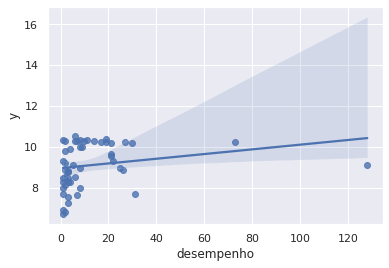

In [20]:
sns.regplot(x=df_desempenho_pais_total['desempenho'], y=np.log(df_desempenho_pais_total['y']))
plt.show()

### GDP X Desempenho após filtragem

In [21]:
df_desempenho_pais_total[df_desempenho_pais_total['desempenho']>60]

,region,desempenho,Country,GDP ($ per capita),nome,_x,_y,clustering coefficient,y,c
16,Germany,73,Germany,27600.0,Germany,5.462417,4.891956,0.532428,27600.0,0.532428
42,Russia,128,Russia,8900.0,Russia,5.556105,5.619676,0.547511,8900.0,0.547511
52,USA,67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
df_desempenho_pais_filtered = df_desempenho_pais_total[df_desempenho_pais_total['desempenho']<60]


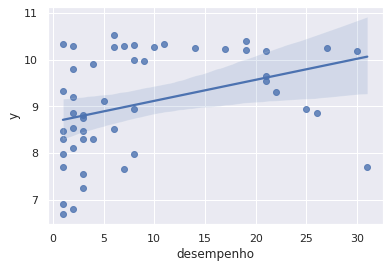

In [23]:
sns.regplot(x=df_desempenho_pais_filtered['desempenho'], y=np.log(df_desempenho_pais_filtered['y']))
plt.show()

In [24]:
model = smf.ols(data=df_desempenho_pais_filtered, formula='desempenho ~ y')
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             desempenho   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     5.436
Date:                Fri, 12 Nov 2021   Prob (F-statistic):             0.0241
Time:                        00:54:39   Log-Likelihood:                -173.86
No. Observations:                  49   AIC:                             351.7
Df Residuals:                      47   BIC:                             355.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.4825      1.938      2.830      0.007       1.585       9.380
y              0.0002      0.000      2.332      0.024    3.39e-05       0.000
==============================================================================
Omnibus:                       13.020   Durbin-Watson:                   1.865
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               13.809
Skew:                           1.253   Prob(JB):                      0.00100
Kurtosis:                       3.697   Cond. No.                     2.89e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.89e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Clustering Coefficient X Desempenho 

In [25]:
df_desempenho_cluster = df_desempenho_pais_total.dropna(subset=['clustering coefficient'])

In [26]:
model = smf.ols(data=df_desempenho_cluster, formula='desempenho ~ c')
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             desempenho   R-squared:                       0.478
Model:                            OLS   Adj. R-squared:                  0.467
Method:                 Least Squares   F-statistic:                     44.85
Date:                Fri, 12 Nov 2021   Prob (F-statistic):           1.95e-08
Time:                        00:54:39   Log-Likelihood:                -209.88
No. Observations:                  51   AIC:                             423.8
Df Residuals:                      49   BIC:                             427.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     94.7768     12.456      7.609      0.000      69.745     119.808
c            -97.7041     14.588     -6.697      0.000    -127.021     -68.388
==============================================================================
Omnibus:                       76.216   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1020.160
Skew:                           3.931   Prob(JB):                    2.99e-222
Kurtosis:                      23.452   Cond. No.                         11.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

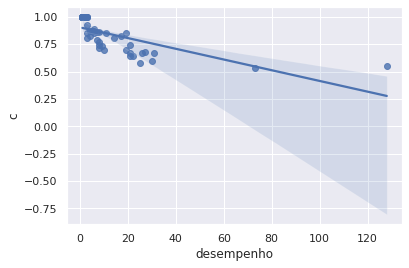

In [27]:
sns.regplot(x=df_desempenho_cluster['desempenho'], y=df_desempenho_cluster['c'])
plt.show()

### Clustering Coefficient X Desempenho após filtragem

In [28]:
df_desempenho_cluster = df_desempenho_pais_filtered.dropna(subset=['clustering coefficient'])

In [29]:
model = smf.ols(data=df_desempenho_cluster, formula='desempenho ~ c')
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             desempenho   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     132.6
Date:                Fri, 12 Nov 2021   Prob (F-statistic):           2.79e-15
Time:                        00:54:39   Log-Likelihood:                -143.70
No. Observations:                  49   AIC:                             291.4
Df Residuals:                      47   BIC:                             295.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     57.4336      4.260     13.482      0.000      48.863      66.004
c            -56.7575      4.929    -11.514      0.000     -66.674     -46.841
==============================================================================
Omnibus:                        0.486   Durbin-Watson:                   1.794
Prob(Omnibus):                  0.784   Jarque-Bera (JB):                0.112
Skew:                           0.098   Prob(JB):                        0.946
Kurtosis:                       3.126   Cond. No.                         12.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

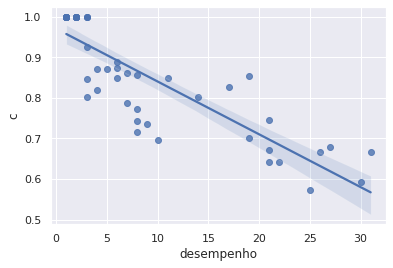

In [30]:
sns.regplot(x=df_desempenho_cluster['desempenho'], y=df_desempenho_cluster['c'])
plt.show()

___

# Amostragem DEPOIS da década de 1990
---

In [31]:
#carrega dados
df = pd.read_csv('athlete_events.csv')
df_noc = pd.read_csv('noc_regions.csv')
df_gdp = pd.read_csv('countries of the world.csv')

In [32]:
#junta ambas as tabelas
df_merge_original=df.merge(df_noc,how="left",on="NOC")

#dropa linhas sem a região
df_merge_original=df_merge_original.dropna(subset=['region'])

### Amostragem
---

In [33]:
#filtra somente datas posteriores a 1970
df_merge_after=df_merge_original[df_merge_original["Year"] >= 2000]

### Análise
---

In [34]:
#cria grafo não-dirigido
g = Graph(directed=False)
c = Graph(directed=False) 

In [35]:
df_merge_after['desempenho'] = df_merge_after['Medal'].apply(lambda x: desempenho(x))

#dropa valores duplicados
df_desempenho = df_merge_after.drop_duplicates(subset=["Year","Sport","region"])

#remove paises com desempenho 0
df_desempenho = df_desempenho.loc[df_desempenho.desempenho>0]

#pega o desempenho por país por esporte
df_desempenho_pais = df_desempenho[["Sport", "region", "desempenho"]].groupby(["Sport", "region"], as_index=False).sum()

#calcula o desemepnho médio por esporte
df_desempenho_media = df_desempenho_pais.groupby(["Sport"]).mean()

#adiciona o desempenho médio por esporte na tabela
df_desempenho_pais["media"] = df_desempenho_pais["Sport"].apply(lambda x: 
              media(x, df_desempenho_media))

#ajusta nome dos países na tabela
df_gdp['Country'] = df_gdp['Country'].apply(lambda x: elimina_ultimo_caracter(x))

#dicionário com os nomes corretos
dic_paises_nome = {
    'South Korea': 'Korea, South',
    'USA': 'United States',
    'UK': 'United Kingdom',
    'North Korea': 'Korea, North',
    'Ivory Coast': "Cote d'Ivoire"
}

#acerta o nome dos países
df_desempenho_pais['region'] = df_desempenho_pais['region'].apply(lambda x: acerta_nome_paises(x, dic_paises_nome)) 

#pega informações sobre cada país
df_desempenho_pais = df_desempenho_pais.merge(df_gdp[["Country","GDP ($ per capita)"]],
                                              how='left',
                                              left_on="region",
                                              right_on="Country",)

#remove alguns países irrelevantes
df_desempenho_pais = df_desempenho_pais.dropna(subset=['GDP ($ per capita)'])


In [36]:
df_merge_original.describe()

,ID,Age,Height,Weight,Year
count,270746.000000,261286.000000,210668.000000,207964.000000,270746.000000
mean,68230.259254,25.560003,175.344741,70.710209,1978.360279
std,39018.124171,6.392576,10.519332,14.350083,29.883741
min,1.000000,10.000000,127.000000,25.000000,1896.000000
25%,34631.000000,21.000000,168.000000,60.000000,1960.000000
50%,68187.500000,24.000000,175.000000,70.000000,1988.000000
75%,102068.750000,28.000000,183.000000,79.000000,2002.000000
max,135571.000000,97.000000,226.000000,214.000000,2016.000000


In [37]:
#pega todos os times
lista_teams = df_desempenho_pais.region.unique().tolist()

#pega todos os eventos
lista_eventos = df_desempenho_pais.Sport.unique().tolist()

g.vp['tipo'] = g.new_vp('object')
g.vp['nome'] = g.new_vp('object')
g.vp['color'] = g.new_vp('object')

lista_vertices = lista_teams+lista_eventos

#cria os times como vértices
cria_vertices(g, lista_vertices, len(lista_teams))
print('número de vértices de g:', g.num_vertices())

lista_arestas = list()

#preenche a lista e o dicionario de acordo com as partidas e ocorrencias
df_fake = df_desempenho_pais.apply(lambda x: 
              arestas(x.region, x.Sport, x.desempenho, x.media, lista_arestas),
              axis=1)

create_edgs_links(lista_arestas, g)

número de vértices de g: 134


### Análise 2
---

In [38]:
c.vp['nome'] = c.new_vp('object') #adiciona propriedade aos vértices
c.ep['peso'] = c.new_ep('object') #adiciona propriedade as arestas

cria_nome_times(g, c) #cria vertíces

dicionario_one_mode, lista_one_mode = lista_esporte_por_time(g)

dist = cria_arestas(c, dicionario_one_mode, lista_one_mode)

### Visualizando grafo C
---

In [39]:
m = draw_gt.sfdp_layout(c)
move_gt(c, m)

save_gt(c, 'exemplo_c.net.gz')

r = netpixi.render('./exemplo_c.net.gz', infinite=True)

In [40]:
r.graph(kscale=5) # Isto aumenta o tamanho dos nomes.
r.vertex_default(size=6)
r.vertex_set_key('nome')
r.edge_scale('peso', 1, 3)

### Cluster coefficient
---

In [41]:
cluster = clustering.local_clustering(c)

c.vp['clustering coefficient'] = cluster

dft = pd.DataFrame({k: list(v) for k, v in c.vp.items()})

dft = dft.loc[dft['clustering coefficient'] != 0]

### Salvando grafo e visualizando
---

In [42]:
top = []
for v in g.vertices():
    if g.vp['tipo'][v] == 'time':
        top.append(v)
        
m = draw_gt.bipartite_layout(g, top)
move_gt(g, m)

save_gt(g, 'exemplo.net.gz')

r = netpixi.render('./exemplo.net.gz')

In [43]:
# mudar a cor de fundo do grafo
r.graph(color=0xffffff)

# mudar a cor e o tamanho dos vértices
r.vertex_default(color=0x000000, size=10)

# mudar a cor, a espessura e a curvatura das arestas
r.edge_default(color=0x000000, width=1, curve1=0, curve2=0)

# mudar uma aresta específica a partir dos ids de sua origem e destino
r.edge(0, 1, color=0x0000ff, width=2)

r.graph(kscale=0.5) # Isto aumenta o tamanho dos nomes.
r.vertex_default(size=6)
r.vertex_set_key('nome')
r.edge_scale('peso', 1, 3)

### Regressão
---

### GDP X Desempenho

In [44]:
df_desempenho_pais_total = df_desempenho[["region", "desempenho"]].groupby(["region"], as_index=False).sum()


In [45]:

df_desempenho_pais_total = df_desempenho_pais_total.merge(df_gdp[["Country","GDP ($ per capita)"]],
                                              how='left',
                                              left_on="region",
                                              right_on="Country")


In [46]:

df_desempenho_pais_total = df_desempenho_pais_total.merge(dft,
                                              how='left',
                                              left_on="region",
                                              right_on="nome")


In [47]:

df_desempenho_pais_total['y'] = df_desempenho_pais_total['GDP ($ per capita)']
df_desempenho_pais_total['c'] = df_desempenho_pais_total['clustering coefficient']

In [48]:
model = smf.ols(data=df_desempenho_pais_total, formula='desempenho ~ y')
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             desempenho   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     12.95
Date:                Fri, 12 Nov 2021   Prob (F-statistic):           0.000563
Time:                        00:54:42   Log-Likelihood:                -336.85
No. Observations:                  79   AIC:                             677.7
Df Residuals:                      77   BIC:                             682.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.4256      3.077      2.088      0.040       0.298      12.553
y              0.0007      0.000      3.599      0.001       0.000       0.001
==============================================================================
Omnibus:                       73.760   Durbin-Watson:                   2.143
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              538.993
Skew:                           2.880   Prob(JB):                    9.10e-118
Kurtosis:                      14.426   Cond. No.                     2.53e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.53e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

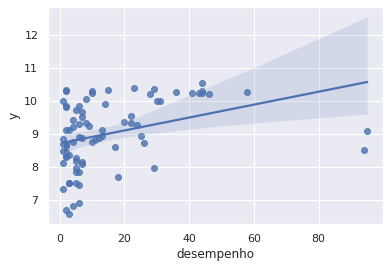

In [49]:
sns.regplot(x=df_desempenho_pais_total['desempenho'], y=np.log(df_desempenho_pais_total['y']))
plt.show()

### GDP X Desempenho após filtragem

In [50]:
df_desempenho_pais_filtered = df_desempenho_pais_total[df_desempenho_pais_total['desempenho']<80]


In [51]:
df_desempenho_pais_total[df_desempenho_pais_total['desempenho']>80]

,region,desempenho,Country,GDP ($ per capita),nome,_x,_y,clustering coefficient,y,c
14,China,94,China,5000.0,China,5.687757,3.878397,0.593897,5000.0,0.593897
63,Russia,95,Russia,8900.0,Russia,4.831302,4.307494,0.522233,8900.0,0.522233
80,USA,84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
df_desempenho_pais_filtered = df_desempenho_pais_total[df_desempenho_pais_total['desempenho']<80]


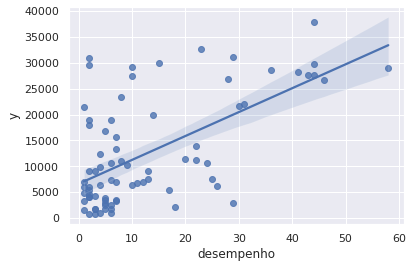

In [53]:
sns.regplot(x=df_desempenho_pais_filtered['desempenho'], y=(df_desempenho_pais_filtered['y']))
plt.show()

In [54]:
model = smf.ols(data=df_desempenho_pais_filtered, formula='desempenho ~ y')
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             desempenho   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.361
Method:                 Least Squares   F-statistic:                     44.00
Date:                Fri, 12 Nov 2021   Prob (F-statistic):           4.49e-09
Time:                        00:54:43   Log-Likelihood:                -292.69
No. Observations:                  77   AIC:                             589.4
Df Residuals:                      75   BIC:                             594.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.8338      1.966      1.441      0.154      -1.082       6.750
y              0.0008      0.000      6.633      0.000       0.001       0.001
==============================================================================
Omnibus:                        2.834   Durbin-Watson:                   2.321
Prob(Omnibus):                  0.242   Jarque-Bera (JB):                2.093
Skew:                           0.358   Prob(JB):                        0.351
Kurtosis:                       3.375   Cond. No.                     2.56e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.56e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Clustering Coefficient X Desempenho 

In [55]:
df_desempenho_cluster = df_desempenho_pais_total.dropna(subset=['clustering coefficient'])

In [56]:
model = smf.ols(data=df_desempenho_cluster, formula='np.log(desempenho) ~ c')
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(desempenho)   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                     239.9
Date:                Fri, 12 Nov 2021   Prob (F-statistic):           2.30e-25
Time:                        00:54:43   Log-Likelihood:                -69.463
No. Observations:                  79   AIC:                             142.9
Df Residuals:                      77   BIC:                             147.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.6822      0.370     20.757      0.000       6.945       8.419
c             -6.9150      0.446    -15.488      0.000      -7.804      -6.026
==============================================================================
Omnibus:                        1.079   Durbin-Watson:                   2.064
Prob(Omnibus):                  0.583   Jarque-Bera (JB):                1.099
Skew:                           0.169   Prob(JB):                        0.577
Kurtosis:                       2.531   Cond. No.                         11.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

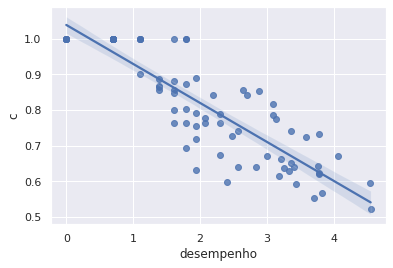

In [57]:
sns.regplot(x=np.log(df_desempenho_cluster['desempenho']), y=df_desempenho_cluster['c'])
plt.show()

### Clustering Coefficient X Desempenho após filtragem


In [58]:
df_desempenho_pais_filtered = df_desempenho_pais_total[df_desempenho_pais_total['desempenho']<80]

In [59]:
df_desempenho_cluster = df_desempenho_pais_filtered.dropna(subset=['clustering coefficient'])

In [60]:
model = smf.ols(data=df_desempenho_cluster, formula='np.log(desempenho) ~ c')
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(desempenho)   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     211.3
Date:                Fri, 12 Nov 2021   Prob (F-statistic):           1.62e-23
Time:                        00:54:43   Log-Likelihood:                -66.810
No. Observations:                  77   AIC:                             137.6
Df Residuals:                      75   BIC:                             142.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.4766      0.384     19.468      0.000       6.712       8.242
c             -6.6879      0.460    -14.537      0.000      -7.604      -5.771
==============================================================================
Omnibus:                        1.230   Durbin-Watson:                   2.050
Prob(Omnibus):                  0.541   Jarque-Bera (JB):                1.270
Skew:                           0.227   Prob(JB):                        0.530
Kurtosis:                       2.565   Cond. No.                         11.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

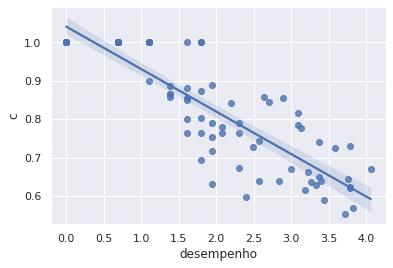

In [61]:
sns.regplot(x=np.log(df_desempenho_cluster['desempenho']), y=df_desempenho_cluster['c'])
plt.show()